In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Homogeneous Poisson

## Data Generation

In [2]:
def generate_poisson_points(kappa, scale, region, num_samples=10000):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    - num_samples (int): Number of candidate points to sample for rejection sampling.
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    max_intensity = torch.max(intensity).item()
    accept_prob = intensity / max_intensity
    uniform_samples = np.random.uniform(0, 1, size=num_samples)
    accepted = uniform_samples < accept_prob.numpy()
    
    return candidates[accepted].numpy()

In [77]:
kappa1 = torch.tensor([1.0])
kappa2 = torch.tensor([100.0])
scale = torch.tensor([0.5])

region = ((0, 1), (0, 1))  # A square domain in 2D

In [ ]:
x_t = generate_poisson_points(kappa1, scale, region)
x_t2 = generate_poisson_points(kappa2, scale, region)

1987

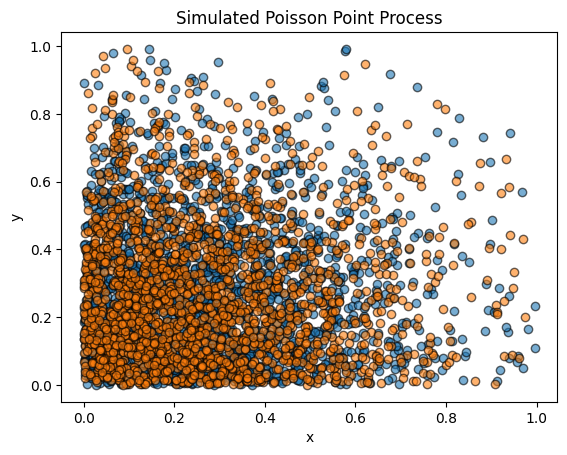

In [79]:
plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.6, edgecolor='k')
plt.scatter(x_t2[:, 0], x_t2[:, 1], alpha=0.6, edgecolor='k')
plt.title("Simulated Poisson Point Process")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Poisson Model

In [ ]:
class Poisson(nn.Module):
    def __init__(self, dimensions):
        super(Poisson, self).__init__()
        # self.kappa = nn.Parameter(torch.abs(torch.randn(dimensions, dtype=torch.float64)))
        self.scale = nn.Parameter(torch.abs(torch.randn(dimensions, dtype=torch.float64)))
        
    def forward(self, x):
        squared_norm = torch.sum(x**2, dim=-1)
        return -squared_norm / self.scale
        # return torch.log(self.kappa) - squared_norm / self.scale

In [81]:
def compute_psi(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(
        nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
    return psi

In [82]:
def J(x_t, model):
    T = len(x_t)
    total_sum = 0
    for t in range(T):
        x = x_t[t]
        psi_x = compute_psi(x, model)

        divergence = 0
        for i in range(x.shape[-1]):
            gradient = torch.autograd.grad(
                psi_x[..., i].sum(), x, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]
        norm_squared = (psi_x ** 2).sum()

        total_sum += 0.5 * norm_squared + divergence
    return total_sum / T

In [86]:
def optimize_theta(
        x_t, dim, nn_model,
        num_epochs=1000, learning_rate=1e-3,
        ):
    model = nn_model(dim)
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses = []
    # estimated_kappa = []
    estimated_scale = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t, dtype=torch.float64)
        loss = J(x_t_tensor, model)

        loss.backward()  
        optimizer.step()

        # print(f"Epoch {epoch} kappa grad:", model.kappa.grad)
        # print(f"Epoch {epoch} scale grad:", model.scale.grad)
        # print(f"Epoch {epoch} kappa:", model.kappa)
        print(f"Epoch {epoch} scale:", model.scale)
        losses.append(loss.item())
        # estimated_kappa.append(model.kappa.detach().numpy().copy())
        estimated_scale.append(model.scale.detach().numpy().copy())
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_scale

In [87]:
epochs = 50
model, losses, estimated_scale = optimize_theta(
    x_t, 1, Poisson, num_epochs=epochs, learning_rate=1e-3,
    )

Epoch 0 scale: Parameter containing:
tensor([1.7071], dtype=torch.float64, requires_grad=True)
Epoch 0/50, Loss: -1.3153168249953253
Epoch 1 scale: Parameter containing:
tensor([1.7059], dtype=torch.float64, requires_grad=True)
Epoch 1/50, Loss: -1.3167929153322082
Epoch 2 scale: Parameter containing:
tensor([1.7044], dtype=torch.float64, requires_grad=True)
Epoch 2/50, Loss: -1.318567448797268
Epoch 3 scale: Parameter containing:
tensor([1.7027], dtype=torch.float64, requires_grad=True)
Epoch 3/50, Loss: -1.3207015452313395
Epoch 4 scale: Parameter containing:
tensor([1.7006], dtype=torch.float64, requires_grad=True)
Epoch 4/50, Loss: -1.3232691871258224
Epoch 5 scale: Parameter containing:
tensor([1.6981], dtype=torch.float64, requires_grad=True)
Epoch 5/50, Loss: -1.3263600797676436
Epoch 6 scale: Parameter containing:
tensor([1.6951], dtype=torch.float64, requires_grad=True)
Epoch 6/50, Loss: -1.3300832148524295
Epoch 7 scale: Parameter containing:
tensor([1.6916], dtype=torch.floa

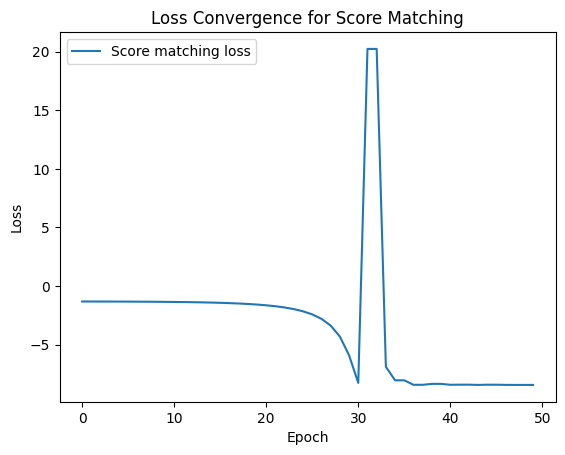

In [88]:
plt.plot(losses, label="Score matching loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()


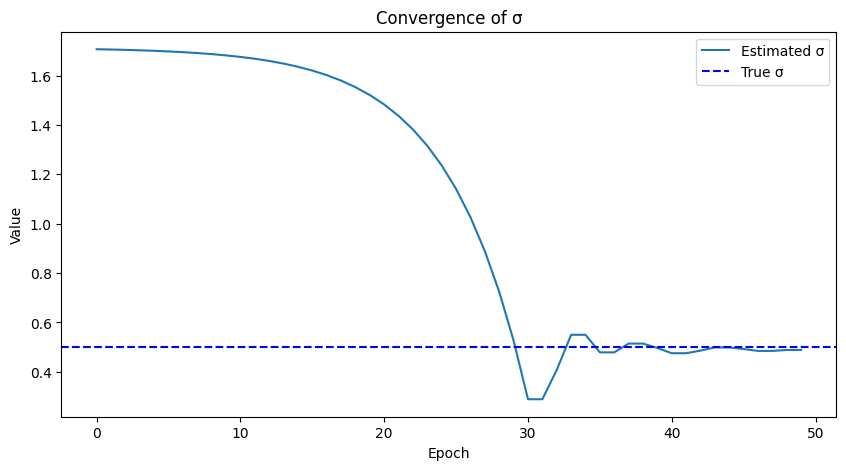

In [89]:
# plt.figure(figsize=(10, 5))
# plt.plot(estimated_kappa, label="Estimated κ")
# plt.axhline(kappa[0], color='orange', linestyle='--', label="True κ")
# plt.xlabel('Epoch')
# plt.ylabel('Value')
# plt.legend()
# plt.title('Convergence of κ')
# plt.show()

plt.figure(figsize=(10, 5))
plt.plot(estimated_scale, label="Estimated σ")
plt.axhline(scale[0], color='blue', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of σ')
plt.show()

In [90]:
# print("Estimated kappa:", model.kappa)
# print("True kappa:", kappa)
print("Estimated scale:", model.scale)
print("True scale:", scale)

Estimated scale: Parameter containing:
tensor([0.4884], dtype=torch.float64, requires_grad=True)
True scale: tensor([0.5000])
